In [ ]:
#pip install opencv-python==4.1.0.25

In [1]:
import cv2
import argparse
import numpy as np

In [2]:
# function to get the output layer names 
# in the architecture

def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

classes = None
classes = open('darknet/data/coco.names').read().strip().split('\n')
    
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))
# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h,label,noOfcars):
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label +" "+ str(round(confidence,2)) , (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

#function to add text on image
def text_on_image(img, class_id,noOfcars,fps):
    color = COLORS[class_id]
    cv2.putText(img, "No:cars in frame: " +str(noOfcars), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    cv2.putText(img, "FPS: " +str(round(fps,2)), (30,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)



In [3]:
global COLORS
# read pre-trained model and config file
net = cv2.dnn.readNet('darknet/cfg/yolov3-tiny.cfg', 'darknet/cfg/yolov3-tiny.weights')
def detectObject(img,frameNumber):
    from keras.preprocessing import image
    # read input image
    img = img
    Width = img.shape[1]
    Height = img.shape[0]

    scale = 0.00392

    # read class names from text file
    classes = None
    classes = open('darknet/data/coco.names').read().strip().split('\n')
    
    # generate different colors for different classes 
    COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

    # create input blob 
    blob = cv2.dnn.blobFromImage(img, scale, (416,416), (0,0,0), True, crop=False)

    # set input blob for the network
    net.setInput(blob)
    # run inference through the network
    # and gather predictions from output layers
    outs = net.forward(get_output_layers(net))

    # initialization
    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4

    # for each detetion from each output layer 
    # get the confidence, class id, bounding box params
    # and ignore weak detections (confidence < 0.5)
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])
                


    # apply non-max suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # go through the detections remaining
    # after nms and draw bounding box
    
    suv=0
    sedan=0
    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        x = round(x)
        y = round(y)
        w = round(w)
        h = round(h)
        cropped = img[x:x+w, y:y+h]
        labels={}
        labels[0]="SEDAN"
        labels[1]="SUV"
        img_tensor = image.img_to_array(cropped)                    # (height, width, channels)
        img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
        img_tensor /= 255. 
        tb._SYMBOLIC_SCOPE.value=False
        index = np.argmax(model.predict(img_tensor))
        draw_bounding_box(img, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h),labels[index],len(indices))
        
        if labels[index]=="SEDAN":
            sedan+=1
        elif labels[index]=="SUV":
            suv+=1

    # release resources
    elapsed_time = time.time() - starting_time
    fps = frameNumber/elapsed_time
    text_on_image(img, 1,len(indices),fps)
    
    
    cv2.destroyAllWindows()
    return img,sedan,suv,len(indices),round(fps,2)
    

In [4]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as tb

Using TensorFlow backend.


In [5]:
mobile = keras.applications.mobilenet.MobileNet()
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
#Code to check predictions from original Mobilenet model
# preprocessed_image = prepare_image('output/frame0.jpg')
# predictions = mobile.predict(preprocessed_image)
# results = imagenet_utils.decode_predictions(predictions)
# results

In [ ]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='sigmoid')(x) #final layer with softmax activation
# preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)

In [ ]:
#Code to see layer details in model
# for i,layer in enumerate(model.layers):
#     print(i,layer.name)

In [ ]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [ ]:
import tensorflow as tf
#importing training images split as train and test, image resized to 224,224 
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,preprocessing_function=preprocess_input)
X_train = image_generator.flow_from_directory(directory='Images',
                                                     batch_size=32,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                      subset="training",
                                                      class_mode='categorical')
label = (X_train.class_indices)
print(label)
X_test = image_generator.flow_from_directory(directory='Images',
                                                     batch_size=32,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                     class_mode='categorical',
                                                     subset="validation")

label_t = (X_test.class_indices)
print(label_t)
labels={}
labels[0]="SEDAN"
labels[1]="SUV"




In [ ]:
# Adam optimizer
# loss function categorical cross entropy
# evaluation metrics accuracy
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(X_train,
                    epochs=10,
                    validation_data=X_test)

In [ ]:
#average Validation accuracy
print("Validation Accuracy of Trained model: ",np.mean(history.history['val_accuracy']))

In [ ]:
model.save('mobileNetv1.h5')

In [6]:
# model.load('mobileNetv1.h5')
model = keras.models.load_model('mobileNetv1.h5')

In [7]:
from threading import Thread, Condition
import time
import random
import pandas as pd

condition = Condition()
queue = []

class ConsumerThread(Thread):
    def run(self):
        global queue
        global starting_time
        global elapsed_time
        i=0
        frameNo=[]
        carCount=[]
        sedan=[]
        suv=[]
        fps_l=[]
        while True:
            try:

                condition.acquire()
                if not queue:
                    #print ("Nothing in queue, consumer is waiting")
                    condition.wait()
                    #print ("Producer added something to queue and notified the consumer")
                img = queue.pop(0)
                output,sedanC,suvC,carC,fps=detectObject(img,i)
                frameNo.append(i+1)
                sedan.append(sedanC)
                suv.append(suvC)
                carCount.append(carC)
                fps_l.append(fps)
                cv2.imwrite("output/frame%d.jpg"%i, output)
                i+=1
                #print ("Consumed")
                condition.release()
                #time.sleep(random.random())
            except AttributeError:
                break;
        elapsed_time = time.time() - starting_time
        print("Total Pipeline Time: ",elapsed_time)
        frame = cv2.imread("output/frame0.jpg")
        height, width, layers = frame.shape
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        video_name = 'output.mp4'
        video = cv2.VideoWriter(video_name, fourcc, 30.0, (width,height))

        for i in range(i+1):
            video.write(cv2.imread("output/frame%d.jpg"%i)) 
        video.release()
        list_of_tuples = list(zip(frameNo, sedan,suv,carCount,fps_l))
        df = pd.DataFrame(list_of_tuples, 
                  columns = ['Frame#', 'SEDAN','SUV','Total',"Output FPS"])
        df.to_csv('output.csv')
    
         

In [8]:
class ProducerThread(Thread):
    def run(self):
        global queue
        vidcap = cv2.VideoCapture('darknet/data/assignment-clip.mp4')
        success,img = vidcap.read()
        count = 0
        while success:
            condition.acquire()     
            success,img = vidcap.read()
            queue.append(img)
            count += 1
            #print ("Produced")
            condition.notify()
            condition.release()
            time.sleep(0.001)
            

In [9]:
global starting_time

#start producer and consumer thread, prints total pipeline time on completion
starting_time = time.time()
ProducerThread().start()
ConsumerThread().start()

Total Pipeline Time:  47.138108015060425


In [10]:
from sklearn.metrics import f1_score


output=pd.read_csv('output.csv')
ytrue=pd.read_csv('groundtruth.csv')

#output["Total"]=output.apply(lambda row: row.SEDAN + row.SUV, axis=1)
output = output[['Frame#', 'SEDAN', 'SUV','Total','Output FPS']].copy()
ytrue.drop(ytrue[ytrue['Frame#'] == 900].index, inplace=True)

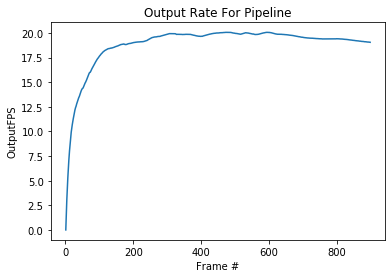

In [12]:
import matplotlib.pyplot as plt
plt.plot(output['Frame#'],output['Output FPS'])
plt.title('Output Rate For Pipeline')
plt.xlabel('Frame #')
plt.ylabel('OutputFPS')
plt.show()

In [13]:
#Average throughput in FPS
print("Average Throughput (in FPS): ",round(output['Output FPS'].mean(),2))

#Time taken for each frame
print("Average Time taken to process each frame (in Seconds): ",round(1/output['Output FPS'].mean(),3))

Average Throughput (in FPS):  18.83
Average Time taken to process each frame (in Seconds):  0.053


In [14]:
#Calculating F1 score for Q1
#precision is given by TP/(TP+FP)
#TP is Total from output file, FP is 0 as we can see from video that there are no incorrect positives
#output['Total']/output['Total'] will always be equal to 1 in our case
#for Recall is given by TP/(TP+FN) - which will be output['total']/ytrue['total']
precision=output['Total']/output['Total']
recall=output['Total']/ytrue['Total']
#f1=2*p*r/(p+r)

In [15]:
#Mean average precision
MAP=precision.mean()
MAR=recall.mean()

In [16]:
f1_objectdetection=2*MAP*MAR/(MAP+MAR)

In [17]:
print("F1 Score for object detection: ", f1_objectdetection)

F1 Score for object detection:  0.8372368747238063


In [18]:
#F1 for classification Q2
#Assumptions made for calculating TP,FP,FN values
#pseudo code
# if output == groundtruth
#    TP=output
#.elseif output>groundtruth
#.   TP=groundtruth
# else
#.   TP=output

TPSed=np.where(output['SEDAN']==ytrue['Sedan'], output['SEDAN'], np.where(output['SEDAN']>ytrue['Sedan'],ytrue['Sedan'],output['SEDAN']))
TPSUV=np.where(output['SUV']==ytrue['SUV'], output['SUV'], np.where(output['SUV']>ytrue['SUV'],ytrue['SUV'],output['SUV']))


# if output == groundtruth
#    FP=0
#.elseif output>groundtruth
#.   FP=output-groundtruth
# else
#.   FP=0

FPSed=np.where(output['SEDAN']==ytrue['Sedan'], 0, np.where(output['SEDAN']>ytrue['Sedan'],output['SEDAN']-ytrue['Sedan'],0))
FPSUV=np.where(output['SUV']==ytrue['SUV'], 0, np.where(output['SUV']>ytrue['SUV'],output['SUV']-ytrue['SUV'],0))


# if output == groundtruth
#    FN=0
#.elseif output<groundtruth
#.   FN=groundtruth-output
# else
#.   FN=0

FNSed = np.where(output['SEDAN']==ytrue['Sedan'], 0, np.where(output['SEDAN']<ytrue['Sedan'],ytrue['Sedan']-output['SEDAN'],0))
FNSUV = np.where(output['SUV']==ytrue['SUV'], 0, np.where(output['SUV']<ytrue['SUV'],ytrue['SUV']-output['SUV'],0))






In [19]:
precision_q2=(TPSed+TPSUV)/(TPSed+TPSUV+FPSed+FPSUV)
recall_q2=(TPSed+TPSUV)/(TPSed+TPSUV+FNSed+FNSUV)

/Users/suryavikram/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [20]:
# Calculating Mean Average Precision and mean average recall
MAP_q2=np.nanmean(precision_q2)
MAR_q2=np.nanmean(recall_q2)

In [21]:
f1_classification=2*MAP_q2*MAR_q2/(MAP_q2+MAR_q2)

In [22]:
print("F1 Score for Classification: ", f1_classification)

F1 Score for Classification:  0.5284187840521777
